# Sentiment Analysis on IMDB reviews: Pytorch implementation of LSTM on top of GloVes

In this notebook, I will try to implement with Pytorch the architecture that I found on this blog:

https://www.oreilly.com/learning/perform-sentiment-analysis-with-lstms-using-tensorflow

which is basically a LSTM on the top of an embedding layer using GloVe pretrained embeddings. I will reuse part of the code presented in the page mentioned above for the data preprocessing.

## Libraries

In [1]:
import numpy as np
import csv
import io
from matplotlib import pyplot

## Loading pretrained embeddings

The pretrained embeddins from GloVe can be downloaded here: https://nlp.stanford.edu/projects/glove/

There are different **word embedding sizes**. The possibilities are 50, 100, 200, 300. We define the one we use next.

In [2]:
word_emb_size = '100'

In [3]:
emb_file_name = '../IMDB_sent_an_TF/glove.6B/glove.6B.' + word_emb_size + 'd.txt'

The code of the next cell comes from https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python#45894001

In [4]:
import pandas as pd
import csv

emb_df = pd.read_table(emb_file_name, sep=" ",
                       index_col=0, header=None, quoting=csv.QUOTE_NONE, encoding='utf-8')

In [5]:
emb_df.shape

(400000, 100)

Then we transform the Pandas data frame into one list `words_list` containing the words (the indexes from the data frame) and one numpy array `word_vectors` containing the corresponding vectors. This last data frame will play the role of our **look-up table** later when we define our model.

In [6]:
words_list = list(emb_df.index)
word_vectors = emb_df.values

## Visualizing the data

In this section we are looking for the threshold we should take as maximum length of a text.

In [7]:
from os import listdir
from os.path import isfile, join

In [8]:
PATH = "/home/aritz/Documents/CS_Programming_Machine_Learning/Machine_learning_and_AI/Online_courses/Fast_AI/fastai/courses/dl1/data/aclImdb/"
#PATH = "/home/aritz/Documents/CS_Programming_Machine_Learning/Machine_learning_and_AI/Online_courses/Fast_AI/fastai/courses/dl1/data/aclImdb_sample2/"
TRAIN = PATH+'train/'
TEST = PATH+'test/'

TRAIN_POS = TRAIN + 'pos/'
TRAIN_NEG = TRAIN + 'neg/'
pos_files_trn = [TRAIN_POS + f for f in listdir(TRAIN_POS) if isfile(join(TRAIN_POS, f))]
neg_files_trn = [TRAIN_NEG + f for f in listdir(TRAIN_NEG) if isfile(join(TRAIN_NEG, f))]

TEST_POS = TEST + 'pos/'
TEST_NEG = TEST + 'neg/'
pos_files_test = [TEST_POS + f for f in listdir(TEST_POS) if isfile(join(TEST_POS, f))]
neg_files_test = [TEST_NEG + f for f in listdir(TEST_NEG) if isfile(join(TEST_NEG, f))]

Next we determine the average number of words in one sample of the training set.

In [9]:
n_words = []
for pf in pos_files_trn:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        n_words.append(counter)       
print('Positive files finished')

for nf in neg_files_test:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        n_words.append(counter)  
print('Negative files finished')

n_files_trn = len(pos_files_trn) + len(neg_files_trn)
n_files_test = len(pos_files_test) + len(neg_files_test)

Positive files finished
Negative files finished


Strangely it seems that there aren't exactly 12500 files in the folders indicated below, as it is supposed to be.

In [10]:
print(len(pos_files_trn))
print(len(neg_files_trn))
print(len(pos_files_test))
print(len(neg_files_test))

print('The total number of files is', n_files_trn)
print('The total number of words in the files is', sum(n_words))
print('The average number of words in the files is', sum(n_words)/len(n_words))

12501
12501
12501
12500
The total number of files is 25002
The total number of words in the files is 5809599
The average number of words in the files is 232.37466501339946


Next we plot an histogram of the number of words in each sample.

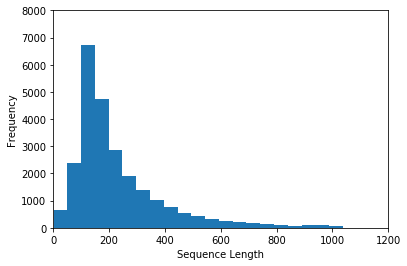

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(n_words, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

Looking at this, 250 words seems a good choice.

In [12]:
max_seq_len = 250

## Mapping words to indexes

In this section we map words to indexes using our words_list variable.

**Question**: It is not entirely clear to me, how the unknown tokens are dealt with. From the code, a new token is assigned the index 399'999. But this corresponds to a word in the GloVe embedding data frame ("sandberger"). I guess that as this word is uncommun, it might serve the purpose of designating unknown words. Even stranger to me is the way padding is used: the author of the code I copied (https://www.oreilly.com/learning/perform-sentiment-analysis-with-lstms-using-tensorflow) uses 0 padding. But in our system, 0 corresponds to "the" and will be treated as a real word by the lstm.

First we do it for a specific file.

We display the content of the file (i.e. the real text).  (I commented out this part because it is useless for the real task)

In [13]:
#fname = pos_files_trn[3] #Can use any valid index (not just 3)
#with open(fname) as f:
#    for lines in f:
#        print(lines)
#        exit

Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters

In [14]:
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

In [15]:
def clean_sentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

We map the given file to a list of indexes where each indexe corresponds to a word, according to the list `words_list`. (I commented out this part because it is useless for the real task)

In [16]:
#first_file = np.zeros((max_seq_len), dtype='int32')
#with open(fname) as f:
#    idx_counter = 0
#    line=f.readline()
#    cleaned_line = clean_sentences(line)
#    split = cleaned_line.split()
#    for word in split:
#        try:
#            first_file[idx_counter] = words_list.index(word)
#        except ValueError:
#            first_file[idx_counter] = 399999 #Vector for unknown words
#        idx_counter = idx_counter + 1
#first_file

In [17]:
ids_dir = '/home/aritz/Documents/CS_Programming_Machine_Learning/Projects/IMDB_sentiment_analysis/IMDB_sent_an_TF/'

### Training set

ids_train will be a matrix, which contains for each file of the training set (first the positive ones, then the negative ones) a row where the columns contain the indices corresponding to the words of the sample file.

The whole computation of the transformation of each text file into a list of indices takes time and needs to be performed only once. The result is saved after the first time and then reloaded for all the other executions.

In [18]:
#ids_train = np.zeros((n_files_trn, max_seq_len), dtype='int32')

#file_counter = 0
#for pf in pos_files_trn:
#    with open(pf, "r") as f:
#        idx_counter = 0
#        line=f.readline()
#        cleaned_line = clean_sentences(line)
#        split = cleaned_line.split()
#        for word in split:
#            try:
#                ids_train[file_counter][idx_counter] = words_list.index(word)
#            except ValueError:
#                ids_train[file_counter][idx_counter] = 399999 #Vector for unkown words
#            idx_counter = idx_counter + 1
#            if idx_counter >= max_seq_len:
#                break
#        file_counter = file_counter + 1

#for nf in neg_files_trn:
#    with open(nf, "r") as f:
#        idx_counter = 0
#        line=f.readline()
#        cleaned_line = clean_sentences(line)
#        split = cleaned_line.split()
#        for word in split:
#            try:
#                ids_train[file_counter][idx_counter] = words_list.index(word)
#            except ValueError:
#                ids_train[file_counter][idx_counter] = 399999 #Vector for unkown words
#            idx_counter = idx_counter + 1
#            if idx_counter >= max_seq_len:
#                break
#        file_counter = file_counter + 1 

In [19]:
#Pass into embedding function and see if it evaluates. 

#np.save('idsMatrixTrain'+word_emb_size, ids_train)

ids_train = np.load(ids_dir+'idsMatrixTrain'+word_emb_size+'.npy')

### Testing set

In [20]:
#ids_test = np.zeros((n_files_test, max_seq_len), dtype='int32')

#file_counter = 0
#for pf in pos_files_test:
#    with open(pf, "r") as f:
#        idx_counter = 0
#        line=f.readline()
#        cleaned_line = clean_sentences(line)
#        split = cleaned_line.split()
#        for word in split:
#            try:
#                ids_test[file_counter][idx_counter] = words_list.index(word)
#            except ValueError:
#                ids_test[file_counter][idx_counter] = 399999 #Vector for unkown words
#            idx_counter = idx_counter + 1
#            if idx_counter >= max_seq_len:
#                break
#        file_counter = file_counter + 1

#for nf in neg_files_test:
#    with open(nf, "r") as f:
#        idx_counter = 0
#        line=f.readline()
#        cleaned_line = clean_sentences(line)
#        split = cleaned_line.split()
#        for word in split:
#            try:
#                ids_test[file_counter][idx_counter] = words_list.index(word)
#            except ValueError:
#                ids_test[file_counter][idx_counter] = 399999 #Vector for unkown words
#            idx_counter = idx_counter + 1
#            if idx_counter >= max_seq_len:
#                break
#        file_counter = file_counter + 1 

#np.save('idsMatrixTest'+word_emb_size, ids_test)

In [21]:
ids_test = np.load(ids_dir+'idsMatrixTest'+word_emb_size+'.npy')

## Labels

Now we also create the **labels** with **one-hot-encoding** ([1, 0] for positive and [0, 1] for negative), as done in the original notebook.

In [22]:
len_pos_trn = len(pos_files_trn)
len_neg_trn = len(neg_files_trn)
y_train = [[1,0] for i in range(len_pos_trn)] + [[0,1] for i in range(len_neg_trn)]

len_pos_test = len(pos_files_test)
len_neg_test = len(neg_files_test)
y_test = [[1,0] for i in range(len_pos_test)] + [[0,1] for i in range(len_neg_test)]

len_trn = len_pos_trn + len_neg_trn
len_test = len_pos_test + len_neg_test

It seems that some premade estimators do not accept one-hot-encoding of the labels as explained here:https://stackoverflow.com/questions/48114258/tensorflow-estimator-number-of-classes-does-not-change

For this reason I create a function which converts a list containing one-hot-incoded labels into a list containing **ordinal encoded** labels.

In [23]:
def onehot_2_ordinal(onehot):
    n_classes = len(onehot[0])
    ordinal = []
    for i in range(len(onehot)):
        for j in range(n_classes):
            if onehot[i][j]==1:
                ordinal.append(j)
    return(ordinal)

In [24]:
y_train_ord = onehot_2_ordinal(y_train)
y_test_ord = onehot_2_ordinal(y_test)

## Definition of the model

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In the next cell, I define a `nn.Module` model which does almost all the transformation we want, i.e. from the embedding of the indexes to the making of the logits. I copied some of the code I found in this tutorial:
https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

Note that using `nn.CrossEntropyLoss()` as loss function is equivalent to combining `nn.LogSoftmax(dim=1)` as last layer of the model together with `nn.NLLLoss()` as loss function. I choose the first option here as it looks more similar to the implementation using TensorFlow and Keras

In [58]:
class GloVeLSTM(nn.Module):
    def __init__(self, weights_matrix, keep_prob, n_lstm_units):
        super(GloVeLSTM, self).__init__()
        self.embeddings = nn.Embedding.from_pretrained(weights_matrix)
        _, self.emb_dim = weights_matrix.shape
        self.embeddings.weight.requires_grad=False
        self.n_lstm_units = n_lstm_units
        self.hidden = self.init_hidden()
        self.lstm = nn.LSTM(input_size=self.emb_dim,
                            hidden_size=n_lstm_units,
                            dropout=1-keep_prob).double()
        self.hidden2bin = nn.Linear(n_lstm_units, 2).double()
        
    def forward(self, inp):
        #Before using the LSTM, we need to clean
        #its hidden and state variable in order
        #to prevent the previous review to influence
        #the output for the new review.
        self.hidden = self.init_hidden()
        emb_vect = self.embeddings(inp)
        #We only care about the output of the LSTM for
        #the last word of the sentence (which is the 
        #first entry of the self.hidden)
        _, self.hidden = self.lstm(
            emb_vect.view(len(inp), 1, -1), self.hidden)
        logits = self.hidden2bin(self.hidden[0].view(1, -1))
        return(logits)
        
        
    def init_hidden(self):
        hidden = (torch.zeros(1, 1, self.n_lstm_units),
                  torch.zeros(1, 1, self.n_lstm_units))
        hidden = (torch.tensor(hidden[0], dtype=torch.float64),
                  torch.tensor(hidden[1], dtype=torch.float64))
        return(hidden)      

In the next cells, I make sure that this model works properly.

In [59]:
classifier = GloVeLSTM(weights_matrix=torch.from_numpy(word_vectors),
                         keep_prob=0.7,
                         n_lstm_units=64)

/home/aritz/anaconda3/envs/mypy36/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30000000000000004 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


## Training of the model

It seems that all input sequences which have a lot of zeros at the end, produce the same logits (without training):

In [60]:
for i in range(10):
    print(ids_train[i][-10:-1])
    print(classifier(torch.from_numpy(np.int64(ids_train[i]))))

[0 0 0 0 0 0 0 0 0]
tensor([[ 0.1036,  0.0015]], dtype=torch.float64)
[0 0 0 0 0 0 0 0 0]
tensor([[ 0.1036,  0.0015]], dtype=torch.float64)
[   116    285    998      7    530    439    413 399999  27015]
tensor([[ 0.1573, -0.0554]], dtype=torch.float64)
[0 0 0 0 0 0 0 0 0]
tensor([[ 0.1036,  0.0015]], dtype=torch.float64)
[   13    37 15890     0     0     0     0     0     0]
tensor([[ 0.1020, -0.0009]], dtype=torch.float64)
[   0 3121    3    0 5317 1468 1351    0 8973]
tensor(1.00000e-02 *
       [[ 8.4240, -9.8198]], dtype=torch.float64)
[0 0 0 0 0 0 0 0 0]
tensor([[ 0.1036,  0.0015]], dtype=torch.float64)
[0 0 0 0 0 0 0 0 0]
tensor([[ 0.1036,  0.0015]], dtype=torch.float64)
[0 0 0 0 0 0 0 0 0]
tensor([[ 0.1036,  0.0015]], dtype=torch.float64)
[0 0 0 0 0 0 0 0 0]
tensor([[ 0.1036,  0.0015]], dtype=torch.float64)


Next we define the **loss function**. From this Quora page: https://www.quora.com/What-are-the-differences-between-maximum-likelihood-and-cross-entropy-as-a-loss-function it seems that the negative log likelihood loss and the binary cross-entropy loss are the same thing.

In [61]:
loss_fcn = nn.CrossEntropyLoss()

For the optimizer, one has to give only the parameters which have `requires_grad=True`, as explained here:
https://discuss.pytorch.org/t/freeze-the-learnable-parameters-of-resnet-and-attach-it-to-a-new-network/949/9

In [62]:
parameters = filter(lambda p: p.requires_grad, classifier.parameters())
optimizer = torch.optim.Adagrad(parameters, lr=0.1)

Next we try to train the model on a single input sequence.

In [63]:
classifier.zero_grad()
inp = torch.from_numpy(np.int64(ids_train[0]))
y = y_train_ord[0:1]
logits = classifier(inp)

In [64]:
type(y)

list

In [65]:
loss = loss_fcn(logits, torch.tensor(y))

In [66]:
loss

tensor(0.6434, dtype=torch.float64)

In [67]:
loss.backward()

In [68]:
optimizer.step()

### Dataset and DataLoader

In [69]:
from torch.utils.data import Dataset, DataLoader

Here we define our custom Dataset. Note that there exists an official dataset for IMDB:

https://torchtext.readthedocs.io/en/latest/datasets.html#imdb

but I won't use it since my goal is to get comfortable with tools that I could later use for any set of data.

In [70]:
class MyIMDBDataset(Dataset):
    
    def __init__(self, ids_matrix, y_ord):
        self.ids_matrix = ids_matrix
        self.y_ord = y_ord
        
    def __len__(self):
        return(self.ids_matrix.shape[0])
    
    def __getitem__(self, idx):
        return((self.ids_matrix[idx], self.y_ord[idx]))

In [71]:
my_dataset = MyIMDBDataset(ids_train, y_train_ord)

In [72]:
inp, label = my_dataset[0]

Note that the `Dataset` object outputs objects having the type that one would expect:

In [73]:
print(type(inp))

<class 'numpy.ndarray'>


In [74]:
print(type(label))

<class 'int'>


In [75]:
inp

array([ 12588,     14,     29, 399999,    319,     34,     20,     14,
         2242,  31631,   2094,  11013,  17614,     22,     47,   1058,
           14,     20,     14,      7, 399999,    319,     42, 255441,
           30,    573,    100,   1299,    296,      0, 399999,  30748,
            3,   2838,   4450,  13819,      0,    402,   4184,     17,
            0,   4442,  14959,  10220,      5,  12588,  60607,  12256,
            0, 399999,     34,   2909,  47119,    461,   4543,   1749,
           25,      0,  12626,   3752,      5,   6801,      4,      0,
         2037,   9742,   1174,     14,  34443,      5, 399999,      0,
         3226,   4260,   1654,    107,    339,     77,    138,     22,
           58,     34,     20,     14, 130086,   5610,      5,  16089,
            0,  23277,   8652,     42,     14,   7206,    983,     37,
          319,     42,   5635,    109,    615,     34,   1952,    306,
        97532,   5319,   2909,  14014,      6,   2158,   5418,      3,
      

Next we create a DataLoader

In [76]:
batch_size = 100

In [77]:
trainloader = DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

Note that when one use the `DataLoader` object, the objects that we want to iterate over are **automatically wrapped inside tensors**, as one can see in the next cells.

In [78]:
for i, data in enumerate(trainloader, 0):
    if i>0:
        break
    print(i)
    inp, label = data
    print(type(inp))
    print(inp)
    print(inp.shape)
    print(type(label))
    print(label)
    print(label.shape)

0
<class 'torch.Tensor'>
tensor([[ 1.0000e+01,  3.5900e+02,  2.8100e+02,  ...,  7.5000e+01,
          1.7000e+02,  1.2930e+03],
        [ 4.1000e+01,  7.6321e+04,  6.4000e+01,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 5.7720e+03,  3.8300e+03,  8.2200e+02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 4.0000e+05,  3.2755e+04,  5.0490e+03,  ...,  1.9870e+03,
          1.0936e+04,  2.0400e+02],
        [ 4.3770e+03,  9.4000e+01,  9.6500e+02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  1.6760e+03,  1.0019e+05,  ...,  0.0000e+00,
          4.8810e+03,  3.0000e+00]], dtype=torch.int32)
torch.Size([100, 250])
<class 'torch.Tensor'>
tensor([ 1,  1,  0,  1,  1,  1,  0,  1,  1,  1,  0,  1,  1,  0,
         1,  1,  1,  0,  1,  0,  0,  0,  0,  0,  1,  1,  1,  1,
         0,  1,  0,  1,  0,  0,  0,  1,  0,  0,  0,  1,  1,  0,
         1,  0,  1,  0,  0,  1,  1,  1,  1,  1,  0,  0,  1,  1,
         0,  0,  0,  0

### Training

The code of the following cell is a variation of what I found on this page: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [79]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inp, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # put the inputs into a torch.tensor
        inp = torch.from_numpy(np.int64(inp))
        logits = classifier(inp)
        loss = loss_fcn(logits, torch.tensor(labels))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

RuntimeError: input.size(-1) must be equal to input_size. Expected 100, got 25000

## Debugging

In the next cells we try to find sources of errors. For this we start by creating some toy data.

In [143]:
keep_prob_toy = 0.7
n_lstm_units_toy = 2
len_vocab_toy = 14
emb_size_toy = 3
seq_len_toy = 4
weights_matrix_toy = torch.from_numpy(np.random.random([len_vocab_toy, emb_size_toy]))

In [144]:
print(weights_matrix_toy)

tensor([[ 0.3443,  0.5233,  0.7177],
        [ 0.1617,  0.0085,  0.9811],
        [ 0.5504,  0.5442,  0.9117],
        [ 0.7510,  0.9430,  0.0491],
        [ 0.1687,  0.2143,  0.6186],
        [ 0.3420,  0.7512,  0.0120],
        [ 0.0893,  0.6593,  0.1254],
        [ 0.4261,  0.4338,  0.8336],
        [ 0.4347,  0.4546,  0.6529],
        [ 0.9873,  0.6314,  0.8121],
        [ 0.2329,  0.7288,  0.8390],
        [ 0.1025,  0.4473,  0.9384],
        [ 0.3217,  0.2832,  0.8762],
        [ 0.5853,  0.7373,  0.2068]], dtype=torch.float64)


In [145]:
ids_toy = np.arange(12)
ids_toy.shape = (3, 4)

In [146]:
ids_toy = ids_toy.astype(np.int32, copy=False)

In [297]:
y_toy = [0, 1, 0]

In [147]:
hidden_toy = (torch.zeros(1, 1, n_lstm_units_toy),
                torch.zeros(1, 1, n_lstm_units_toy))

In [217]:
hidden_toy = (torch.tensor(hidden_toy[0], dtype=torch.float64),
              torch.tensor(hidden_toy[1], dtype=torch.float64))

In [202]:
embeddings_toy = nn.Embedding.from_pretrained(weights_matrix_toy)

In [149]:
_, emb_dim_toy = weights_matrix_toy.shape

In [150]:
emb_dim_toy

3

In [203]:
lstm_toy = nn.LSTM(input_size=emb_dim_toy,
                            hidden_size=n_lstm_units_toy,
                            dropout=1-keep_prob_toy).double()

/home/aritz/anaconda3/envs/mypy36/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30000000000000004 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [204]:
hidden2bin_toy = nn.Linear(n_lstm_units_toy, 2).double()

In [291]:
#logsoft_toy = nn.LogSoftmax(dim=1)

In [317]:
loss_fcn_toy = nn.CrossEntropyLoss()

Next we try to reproduce what the `forward function` would do on our toy data, with this setting:

In [205]:
inp = torch.from_numpy(np.int64(ids_toy[1]))
print(inp)

tensor([ 4,  5,  6,  7])


In [206]:
emb_vect_toy = embeddings_toy(inp)

In [207]:
emb_vect_toy

tensor([[ 0.1687,  0.2143,  0.6186],
        [ 0.3420,  0.7512,  0.0120],
        [ 0.0893,  0.6593,  0.1254],
        [ 0.4261,  0.4338,  0.8336]], dtype=torch.float64)

In [169]:
#emb_vect_toy = torch.tensor(emb_vect_toy, dtype=torch.float32)
print(emb_vect_toy)

tensor([[ 0.1687,  0.2143,  0.6186],
        [ 0.3420,  0.7512,  0.0120],
        [ 0.0893,  0.6593,  0.1254],
        [ 0.4261,  0.4338,  0.8336]])


In [212]:
_, hidden_toy = lstm_toy(
            emb_vect_toy.view(len(inp), 1, -1), hidden_toy)
print(hidden_toy)

(tensor([[[-0.3609, -0.1728]]], dtype=torch.float64), tensor([[[-0.4855, -0.3470]]], dtype=torch.float64))


In [214]:
hidden_toy[0]

tensor([[[-0.3609, -0.1728]]], dtype=torch.float64)

In [215]:
logits_toy = hidden2bin_toy(hidden_toy[0].view(1, -1))

In [292]:
#logits_toy = logsoft_toy(logits_toy)

In [293]:
logits_toy

tensor([[-1.7204, -0.1972]], dtype=torch.float64)

In [319]:
torch.tensor([y_toy[0]])

tensor([[ 0,  1]])

In [320]:
loss_fcn_toy(logits_toy, torch.tensor([0]))

tensor(1.7204, dtype=torch.float64)